In [1]:
import pandas as pd
data = pd.read_csv('Tweets Indonesis.csv')
data['text'] = data['text'].apply(str)
data.columns

Index(['label', 'text'], dtype='object')

Number of rows per label:
 1    11356
 0     8315
-1     7609
Name: label, dtype: int64


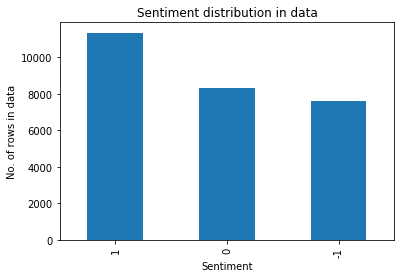

In [2]:
import matplotlib.pyplot as plt 

print("Number of rows per label:")
print(data['label'].value_counts())

# Plotting the sentiment distribution
plt.figure()
pd.value_counts(data['label']).plot.bar(title="Sentiment distribution in data")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in data")
plt.show()

In [3]:
def get_data(top_n = 5000):
    data_positive = data[data['label'] == 1].head(top_n)
    data_negative = data[data['label'] == -1].head(top_n)
    data_neutral= data[data['label'] == 0].head(top_n)
    data_small = pd.concat([data_positive, data_negative, data_neutral])
    return data_small

# Function call to get the top 10000 from each sentiment
data_small = get_data(top_n=7500)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(data_small['label'].value_counts())
data_small.head(10)

After segregating and taking equal number of rows for each sentiment:
-1    7500
 1    7500
 0    7500
Name: label, dtype: int64


,label,text
0,1,suka banget cleanser cocok udah banget gonta g...
1,1,produk klaim makeup removal gak guna makeup re...
2,1,thanks god for this product produk udah cocok ...
3,1,another favorite product from cetaphil neng ba...
4,1,kaget cleanser busa biasa suka cleanser gentle...
5,1,so far cocok cetaphil purchase kali botol paka...
6,1,my hg cleanser kulit yg oily kering arah dehid...
7,1,setia cethapil clenaser wajah produk wajah ber...
8,1,really really love this cleanser kulit wajah s...
9,1,cetaphil bikin kulit sehat bgt gatel kering be...


In [4]:
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
data_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in data_small['text']] 
print(data_small['tokenized_text'].head(10))

0    [suka, banget, cleanser, cocok, udah, banget, ...
1    [produk, klaim, makeup, removal, gak, guna, ma...
2    [thanks, god, for, this, product, produk, udah...
3    [another, favorite, product, from, cetaphil, n...
4    [kaget, cleanser, busa, biasa, suka, cleanser,...
5    [so, far, cocok, cetaphil, purchase, kali, bot...
6    [my, hg, cleanser, kulit, yg, oily, kering, ar...
7    [setia, cethapil, clenaser, wajah, produk, waj...
8    [really, really, love, this, cleanser, kulit, ...
9    [cetaphil, bikin, kulit, sehat, bgt, gatel, ke...
Name: tokenized_text, dtype: object


In [5]:
from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(data_small, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(data_small[['text', 'tokenized_text']], 
                                                        data_small['label'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(data_small)

Value counts for Train sentiments
 1    5303
-1    5235
 0    5212
Name: label, dtype: int64
Value counts for Test sentiments
 0    2288
-1    2265
 1    2197
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                               text  \
0   9499                                            gitu aq   
1  21869                          laku banjir nampak bayang   
2   8987               beneran nih ntar coba g o managernya   
3   7899        banyak ugut terima panjang ugut tindak ugut   
4  16132  bahas dosen hukum islam whoooooaaaaaa untung k...   

                                      tokenized_text  
0                                         [gitu, aq]  
1                     [laku, banjir, nampak, bayang]  
2             [beneran, nih, ntar, coba, managernya]  
3  [banyak, ugut, terima, panjang, ugut, tindak, ...  
4  [bahas, dosen, hukum, islam, whoooooaaaaaa, un...  


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [7]:
from gensim import corpora
# Function to return the dictionary either with padding word or without padding
def make_dict(data_small, padding=True):
    if padding:
        print("Dictionary with padded token added")
        review_dict = corpora.Dictionary([['pad']])
        review_dict.add_documents(data_small['tokenized_text'])
    else:
        print("Dictionary without padding")
        review_dict = corpora.Dictionary(data_small['tokenized_text'])
    return review_dict

# Make the dictionary without padding for the basic models
review_dict = make_dict(data_small, padding=False)

Dictionary without padding


In [8]:
VOCAB_SIZE = len(review_dict)
NUM_LABELS = 3

# Function to make bow vector to be used as input to network
def make_bow_vector(review_dict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
    for word in sentence:
        vec[review_dict.token2id[word]] += 1
    return vec.view(1, -1).float()

In [9]:
def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [10]:
data = torch.randn(5)
print(data)
print("\nProbabilities : ")
print(F.softmax(data, dim=0))
print(F.softmax(data, dim=0).sum())  # Sums to 1 because it is a distribution!
print("\nLog probabilities")
print(F.log_softmax(data, dim=0)) 

tensor([-0.6122, -1.0176, -1.4748,  0.3432,  0.4568])

Probabilities : 
tensor([0.1316, 0.0877, 0.0555, 0.3420, 0.3832])
tensor(1.0000)

Log probabilities
tensor([-2.0283, -2.4336, -2.8909, -1.0729, -0.9593])


In [11]:
# Defining neural network structure
class BoWClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self, num_labels, vocab_size):
        # needs to be done everytime in the nn.module derived class
        super(BoWClassifier, self).__init__()

        # Define the parameters that are needed for linear model ( Ax + b)
        self.linear = nn.Linear(vocab_size, num_labels)

        # NOTE! The non-linearity log softmax does not have parameters! So we don't need
        # to worry about that here

    def forward(self, bow_vec): # Defines the computation performed at every call.
        # Pass the input through the linear layer,
        # then pass that through log_softmax.

        return F.log_softmax(self.linear(bow_vec), dim=1)

In [12]:
#  Initialize the model
bow_nn_model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)
bow_nn_model.to(device)

# Loss Function
loss_function = nn.NLLLoss()
# Optimizer initlialization
optimizer = optim.SGD(bow_nn_model.parameters(), lr=0.01)

In [13]:
import time
start_time = time.time()

# Train the model
for epoch in range(10):
    for index, row in X_train.iterrows():
        # Step 1. Remember that PyTorch accumulates gradients.
        # We need to clear them out before each instance
        bow_nn_model.zero_grad()

        # Step 2. Make BOW vector for input features and target label
        bow_vec = make_bow_vector(review_dict, row['tokenized_text'])
        target = make_target(Y_train['label'][index])

        # Step 3. Run the forward pass.
        probs = bow_nn_model(bow_vec)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss = loss_function(probs, target)
        loss.backward()
        optimizer.step()
print("Time taken to train the model: " + str(time.time() - start_time))

Time taken to train the model: 232.2170045375824


In [16]:
import time
from sklearn.metrics import classification_report
bow_nn_predictions = []
original_lables = []
start_time = time.time()
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['tokenized_text'])
        probs = bow_nn_model(bow_vec)
        bow_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables.append(make_target(Y_test['label'][index]).cpu().numpy()[0])
print(classification_report(original_lables,bow_nn_predictions))
print("Time taken to predict: " + str(time.time() - start_time))

              precision    recall  f1-score   support

           0       0.68      0.67      0.67      2265
           1       0.64      0.68      0.66      2288
           2       0.69      0.65      0.67      2197

    accuracy                           0.67      6750
   macro avg       0.67      0.67      0.67      6750
weighted avg       0.67      0.67      0.67      6750

Time taken to predict: 2.853965997695923
